# Data Science in Agriculture – Practical Notebook
**Student:** Rajat Mishra  
**Course:** M.Sc. Data Science with Big Data Analytics  

Yeh Colab notebook aapke **saare 6 practicals** ke liye sample code contain karta hai.
Aap exam se pehle isko run karke samajh sakte ho, modify bhi kar sakte ho.


In [1]:
# Common imports for multiple practicals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8, 4)
sns.set(style='whitegrid')


## Practical 1 – Web Scraping and Exploratory Data Analysis (EDA)

**Aim:**
- Kisi website se data scrape karna (HTML table).
- Data ko pandas DataFrame mein convert karna.
- Basic EDA karna (head(), info(), describe(), plots).

⚠️ *Note:* Colab mein run karne ke liye internet required hoga. Exam lab mein agar internet na ho,
to aap explanation + offline CSV loading dikhakar EDA part run kar sakte ho.


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.worldometers.info/world-population/population-by-country/"

response = requests.get(url)
print("Status:", response.status_code)

soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table")

rows = table.find_all("tr")

data = []
for row in rows[1:]:
    cols = [col.get_text(strip=True) for col in row.find_all("td")]
    data.append(cols)

column_names = [col.get_text(strip=True) for col in rows[0].find_all("th")]

df_scraped = pd.DataFrame(data, columns=column_names)

df_scraped.head()


Status: 200


,#,Country (or dependency),Population 2025,Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Median Age,Urban Pop %,World Share
0,1,India,"1,463,865,525",0.89%,"12,929,734",492,"2,973,190","−495,753",1.94,28.8,37.1%,17.78%
1,2,China,"1,416,096,094",−0.23%,"−3,225,184",151,"9,388,211","−268,126",1.02,40.1,67.5%,17.20%
2,3,United States,"347,275,807",0.54%,"1,849,236",38,"9,147,420","1,230,663",1.62,38.5,82.8%,4.22%
3,4,Indonesia,"285,721,236",0.79%,"2,233,305",158,"1,811,570","−39,509",2.1,30.4,59.6%,3.47%
4,5,Pakistan,"255,219,554",1.57%,"3,950,390",331,"770,880","−1,235,336",3.5,20.6,34.4%,3.10%



--- HEAD ---
   # Country (or dependency) Population 2025 Yearly Change  Net Change  \
0  1                   India   1,463,865,525         0.89%  12,929,734   
1  2                   China   1,416,096,094        −0.23%  −3,225,184   
2  3           United States     347,275,807         0.54%   1,849,236   
3  4               Indonesia     285,721,236         0.79%   2,233,305   
4  5                Pakistan     255,219,554         1.57%   3,950,390   

  Density (P/Km²) Land Area (Km²) Migrants (net) Fert. Rate Median Age  \
0             492       2,973,190       −495,753       1.94       28.8   
1             151       9,388,211       −268,126       1.02       40.1   
2              38       9,147,420      1,230,663       1.62       38.5   
3             158       1,811,570        −39,509        2.1       30.4   
4             331         770,880     −1,235,336        3.5       20.6   

  Urban Pop % World Share  
0       37.1%      17.78%  
1       67.5%      17.20%  
2       82.8

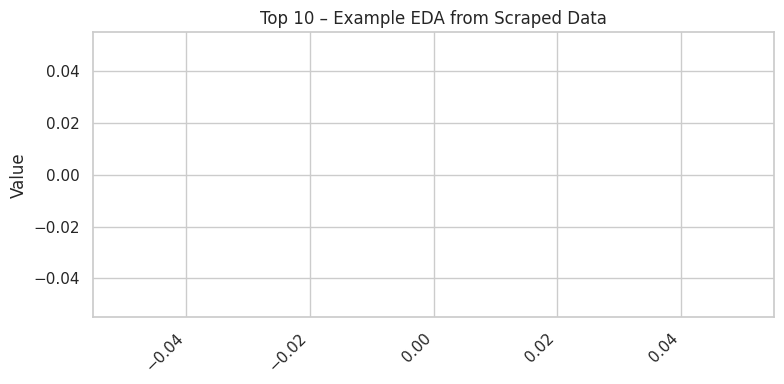

In [4]:
# Basic EDA on scraped data
print('\n--- HEAD ---')
print(df_scraped.head())

print('\n--- INFO ---')
print(df_scraped.info())

print('\n--- DESCRIBE (numeric only after conversion) ---')
df_numeric = df_scraped.copy()
for col in df_numeric.columns[2:]:  # try convert some columns to numeric
    df_numeric[col] = pd.to_numeric(df_numeric[col].str.replace(',', ''), errors='coerce')

print(df_numeric.describe())

# Example bar plot (Top 10 by population if available)
df_plot = df_numeric.dropna().head(10)
plt.figure()
plt.bar(df_plot.iloc[:, 0], df_plot.iloc[:, 2])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 – Example EDA from Scraped Data')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

## Practical 2 – Climate Prediction Using Time Series (ARIMA)

**Aim:** Daily temperature jaisa time series data generate karke ARIMA model se
future values predict karna, aur actual vs predicted ko compare karna.


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# 1. Create synthetic daily temperature data (2019–2023)
date_index = pd.date_range(start='2019-01-01', end='2023-12-31', freq='D')
n_points = len(date_index)

season_pattern = 10 * np.sin(2 * np.pi * date_index.dayofyear / 365)
linear_trend = 0.005 * np.arange(n_points)
random_component = np.random.normal(loc=0, scale=1, size=n_points)

temperature_values = 20 + season_pattern + linear_trend + random_component

weather_df = pd.DataFrame({'Date': date_index, 'Temperature': temperature_values}).set_index('Date')
weather_df.head()

,Temperature
Date,
2019-01-01,19.601580
2019-01-02,21.162402
2019-01-03,18.473871
2019-01-04,21.909524
2019-01-05,21.947144


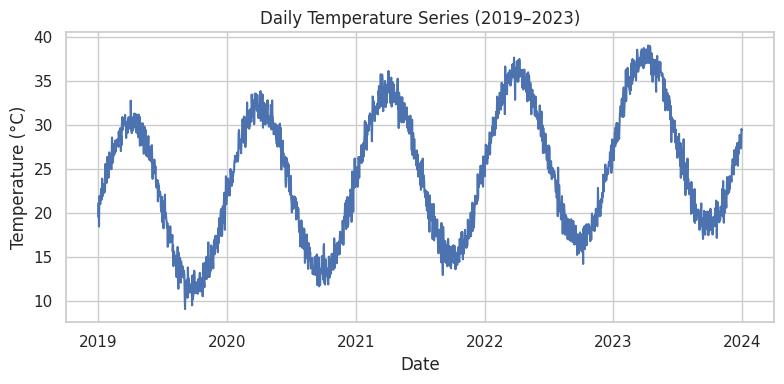

In [6]:
# Plot original time series
plt.figure()
plt.plot(weather_df.index, weather_df['Temperature'])
plt.title('Daily Temperature Series (2019–2023)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()

In [7]:
# Train-Test split (Train: 2019–2022, Test: 2023)
train_cutoff = '2022-12-31'
train_data = weather_df.loc[:train_cutoff]
test_data = weather_df.loc[train_cutoff:]

print('Train size:', len(train_data))
print('Test size:', len(test_data))

Train size: 1461
Test size: 366


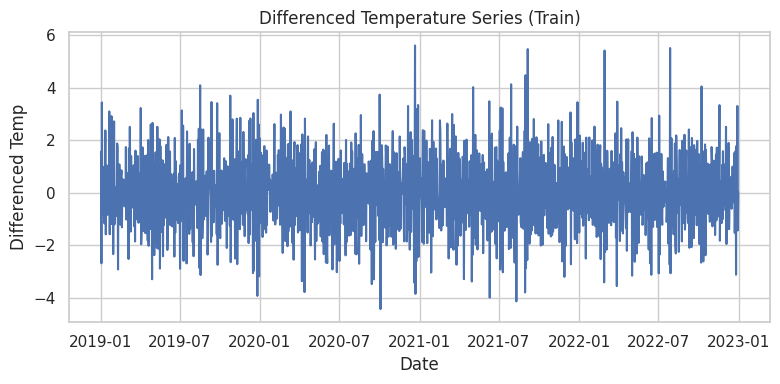

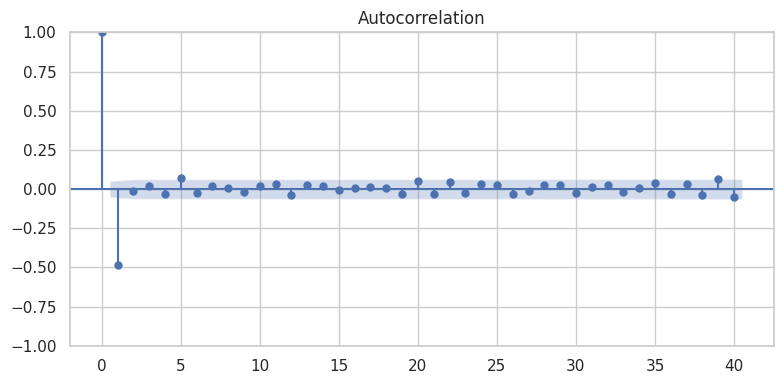

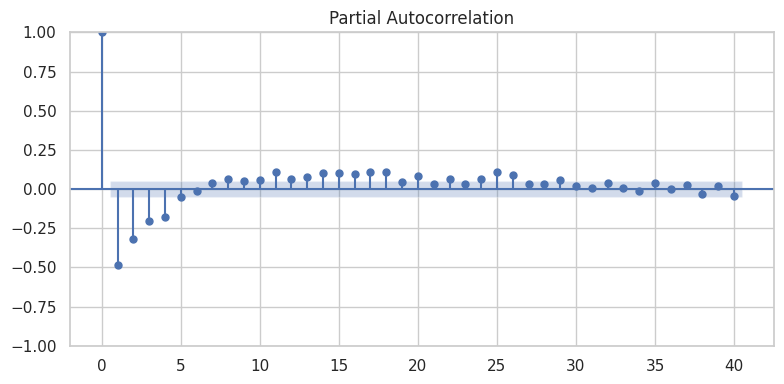

In [8]:
# Differencing to make series stationary
diff_series = train_data['Temperature'].diff().dropna()

plt.figure()
plt.plot(diff_series)
plt.title('Differenced Temperature Series (Train)')
plt.xlabel('Date')
plt.ylabel('Differenced Temp')
plt.tight_layout()
plt.show()

# ACF and PACF plots (for p,q selection)
plot_acf(diff_series, lags=40)
plt.tight_layout()
plt.show()

plot_pacf(diff_series, lags=40, method='ywm')
plt.tight_layout()
plt.show()

In [9]:
# Fit ARIMA model (example order (2,1,1))
p, d, q = 2, 1, 1
model = ARIMA(train_data['Temperature'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 1461
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2298.531
Date:                Sun, 07 Dec 2025   AIC                           4605.062
Time:                        06:10:50   BIC                           4626.206
Sample:                    01-01-2019   HQIC                          4612.950
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1706      0.052     -3.300      0.001      -0.272      -0.069
ar.L2         -0.1096      0.039     -2.800      0.005      -0.186      -0.033
ma.L1         -0.5632      0.048    -11.613      0.0

RMSE: 6.882746940057668


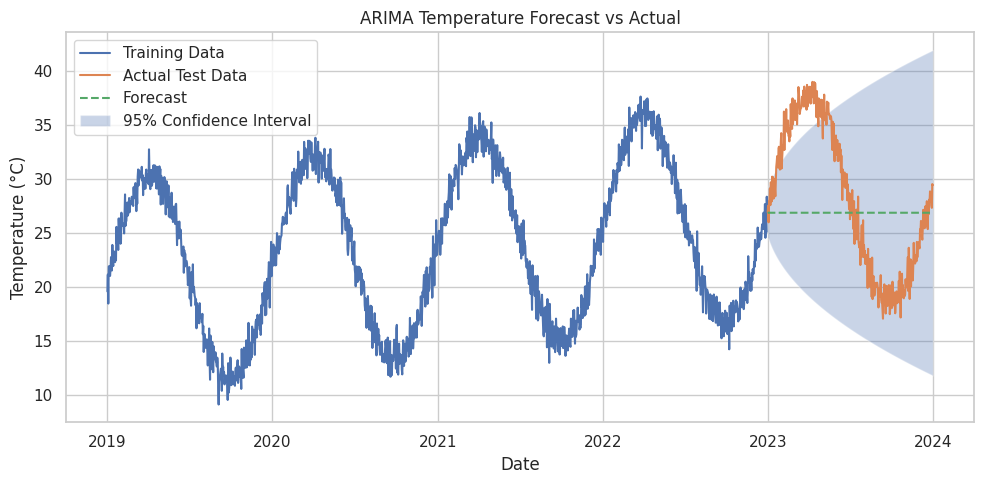

In [10]:
# Forecast for test period
steps = len(test_data)
forecast_obj = model_fit.get_forecast(steps=steps)
forecast = forecast_obj.predicted_mean
forecast_bounds = forecast_obj.conf_int(alpha=0.05)

rmse = np.sqrt(mean_squared_error(test_data['Temperature'], forecast))
print('RMSE:', rmse)

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data['Temperature'], label='Training Data')
plt.plot(test_data.index, test_data['Temperature'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')

plt.fill_between(
    test_data.index,
    forecast_bounds['lower Temperature'],
    forecast_bounds['upper Temperature'],
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('ARIMA Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()

## Practical 3 – Crop Yield Prediction Using Machine Learning

**Aim:** Synthetic crop dataset bana kar regression model (e.g., RandomForestRegressor)
use karke yield predict karna.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Create synthetic crop dataset
np.random.seed(42)
n_samples = 300

soil_types = np.random.choice(['Loam', 'Sandy', 'Clay'], size=n_samples)
rainfall = np.random.randint(300, 1200, size=n_samples)
fertilizer = np.random.randint(50, 250, size=n_samples)
area = np.random.uniform(0.5, 5.0, size=n_samples)

# Simple rule-based yield (just for synthetic data)
base_yield = 2 + 0.003 * rainfall + 0.01 * fertilizer + 0.5 * area
soil_effect = np.where(soil_types == 'Loam', 1.0,
               np.where(soil_types == 'Clay', 0.4, -0.5))
noise = np.random.normal(0, 0.7, size=n_samples)

yield_tph = base_yield + soil_effect + noise

df_crop = pd.DataFrame({
    'Soil_Type': soil_types,
    'Rainfall_mm': rainfall,
    'Fertilizer_kg': fertilizer,
    'Area_hectare': area,
    'Yield_tph': yield_tph
})

df_crop.head()

,Soil_Type,Rainfall_mm,Fertilizer_kg,Area_hectare,Yield_tph
0,Clay,462,70,3.293626,7.932773
1,Loam,1019,213,2.063360,9.322984
2,Clay,980,187,1.441089,8.499337
3,Clay,460,150,3.108425,5.517728
4,Loam,879,201,2.037034,8.765768


In [12]:
# Train-test split
X = df_crop.drop('Yield_tph', axis=1)
y = df_crop['Yield_tph']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess: OneHotEncode soil type, pass numeric as is
categorical_features = ['Soil_Type']
numeric_features = ['Rainfall_mm', 'Fertilizer_kg', 'Area_hectare']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

model = RandomForestRegressor(n_estimators=200, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', model)])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('R2-score:', r2_score(y_test, y_pred))

R2-score: 0.7975373773170439


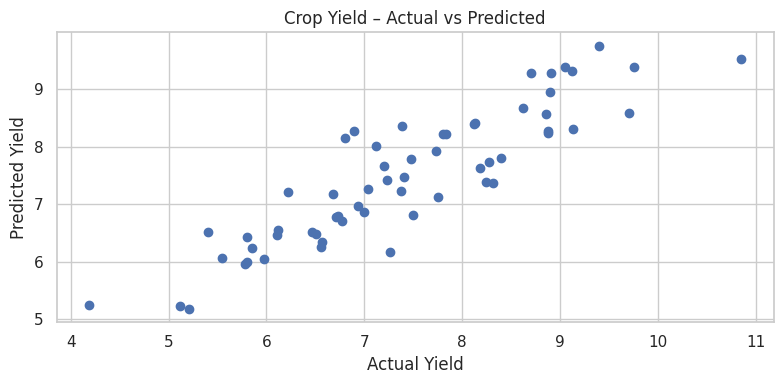

In [13]:
# Plot predicted vs actual
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Crop Yield – Actual vs Predicted')
plt.tight_layout()
plt.show()

## Practical 4 – Plant Disease Detection Using CNN (Image Classification)

**Aim:**
- CNN architecture define karna (Keras/TensorFlow use karke).
- Train/validation generators set karna (folder based images).
- Model compile & train.

⚠️ *Note:* Yahan hum example code de rahe hain. Real run ke liye
aapko `train/` aur `validation/` folders me images arrange karni hongi.


In [15]:
# PRACTICAL 4 – Plant Disease Detection (Sample Demo in ONE CELL)

import os
import numpy as np
from PIL import Image, ImageDraw

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# =============================
# 1. Sample Dataset Generate
# =============================

base_dir = "/content/plant_data"
train_healthy = os.path.join(base_dir, "train", "healthy")
train_diseased = os.path.join(base_dir, "train", "diseased")
val_healthy = os.path.join(base_dir, "val", "healthy")
val_diseased = os.path.join(base_dir, "val", "diseased")

for d in [train_healthy, train_diseased, val_healthy, val_diseased]:
    os.makedirs(d, exist_ok=True)

def make_leaf_image(path, label, healthy=True):
    img = Image.new("RGB", (128, 128), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    if healthy:
        leaf_color = (0, 160, 0)       # green leaf
        spot_color = None
    else:
        leaf_color = (120, 60, 0)      # brown leaf
        spot_color = (220, 220, 0)     # yellow spots

    # leaf
    draw.ellipse((20, 20, 108, 108), fill=leaf_color)

    # spots for diseased
    if spot_color is not None:
        for i in range(3):
            x0 = 40 + i * 15
            y0 = 40 + i * 10
            draw.ellipse((x0, y0, x0 + 15, y0 + 15), fill=spot_color)

    draw.text((5, 5), label, fill=(0, 0, 0))
    img.save(path)

# 10 train images each class, 4 val images each class
for i in range(10):
    make_leaf_image(os.path.join(train_healthy, f"healthy_{i+1}.png"), "healthy", healthy=True)
    make_leaf_image(os.path.join(train_diseased, f"diseased_{i+1}.png"), "diseased", healthy=False)

for i in range(4):
    make_leaf_image(os.path.join(val_healthy, f"healthy_{i+1}.png"), "healthy", healthy=True)
    make_leaf_image(os.path.join(val_diseased, f"diseased_{i+1}.png"), "diseased", healthy=False)

print("Folders & images ready at:", base_dir)
print("Train healthy files:", len(os.listdir(train_healthy)))
print("Train diseased files:", len(os.listdir(train_diseased)))

# =============================
# 2. Data Generators
# =============================

IMG_SIZE = (128, 128)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Class indices:", train_gen.class_indices)

# =============================
# 3. CNN Model Define
# =============================

num_classes = len(train_gen.class_indices)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

# =============================
# 4. Train Model (Small epochs)
# =============================

history = model_cnn.fit(
    train_gen,
    epochs=5,             # exam/demo ke liye enough
    validation_data=val_gen
)

print("Training complete!")


Folders & images ready at: /content/plant_data
Train healthy files: 10
Train diseased files: 10
Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Class indices: {'diseased': 0, 'healthy': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - accuracy: 0.5656 - loss: 0.6668 - val_accuracy: 0.5000 - val_loss: 0.7144
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.7042 - loss: 0.3630 - val_accuracy: 1.0000 - val_loss: 0.0634
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 1.0000 - loss: 0.0760 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 4.8876e-06
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 1.0000 - loss: 2.9388e-04 - val_accuracy: 1.0000 - val_loss: 1.0133e-06
Training complete!


## Practical 5 – Agricultural Product Price Prediction

**Aim:** Synthetic mandi price time series bana kar regression ya simple ML model
use karke future price ya next-day price predict karna.


In [16]:
# Synthetic daily price series (e.g., for wheat)
date_price = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
n_points = len(date_price)

trend = 0.05 * np.arange(n_points)
season = 20 * np.sin(2 * np.pi * date_price.dayofyear / 365)
noise = np.random.normal(0, 5, size=n_points)

base_price = 1500  # base MSP like value
prices = base_price + trend + season + noise

df_price = pd.DataFrame({'Date': date_price, 'Price': prices}).set_index('Date')
df_price.head()

,Price
Date,
2022-01-01,1498.459291
2022-01-02,1503.617331
2022-01-03,1506.514253
2022-01-04,1504.487808
2022-01-05,1498.568046


In [17]:
# Create supervised dataset: use previous 7 days to predict next day price
window = 7
X_list, y_list = [], []
price_values = df_price['Price'].values

for i in range(len(price_values) - window):
    X_list.append(price_values[i:i+window])
    y_list.append(price_values[i+window])

X_price = np.array(X_list)
y_price = np.array(y_list)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor

price_model = GradientBoostingRegressor(random_state=42)
price_model.fit(X_train_p, y_train_p)

y_pred_p = price_model.predict(X_test_p)
print('RMSE (Price Prediction):', np.sqrt(mean_squared_error(y_test_p, y_pred_p)))

RMSE (Price Prediction): 5.891663326473675


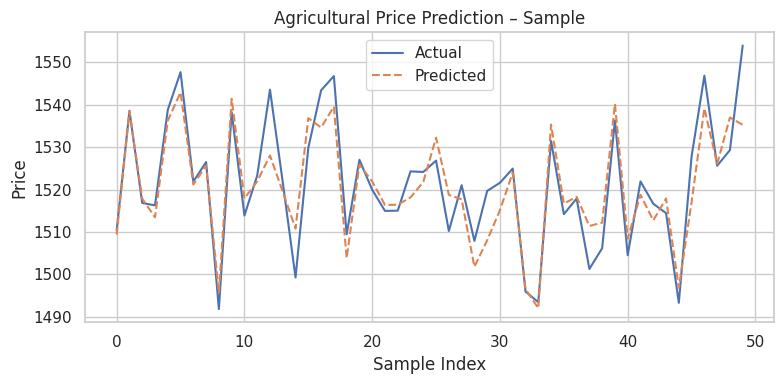

In [18]:
# Plot few actual vs predicted prices
plt.figure()
plt.plot(y_test_p[:50], label='Actual')
plt.plot(y_pred_p[:50], label='Predicted', linestyle='--')
plt.title('Agricultural Price Prediction – Sample')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## Practical 6 – Optimizing Irrigation Using Data Analytics

**Aim:** Synthetic field-level data (soil moisture, rainfall, crop type, area) ka use karke
clustering ya rule-based approach se irrigation suggestion dena.


In [19]:
from sklearn.cluster import KMeans

np.random.seed(10)
n_fields = 200

soil_moisture = np.random.uniform(10, 60, size=n_fields)   # percentage
recent_rainfall = np.random.uniform(0, 50, size=n_fields)  # mm last 3 days
crop_stage = np.random.choice([1, 2, 3], size=n_fields)    # 1=early, 2=mid, 3=late

df_irrig = pd.DataFrame({
    'Soil_Moisture': soil_moisture,
    'Recent_Rainfall': recent_rainfall,
    'Crop_Stage': crop_stage
})

df_irrig.head()

,Soil_Moisture,Recent_Rainfall,Crop_Stage
0,48.566032,40.665804,3
1,11.037597,39.243336,1
2,41.682412,19.670956,1
3,47.440194,43.223960,1
4,34.925351,19.201538,1


In [20]:
# KMeans clustering to group fields
X_irrig = df_irrig.values
kmeans = KMeans(n_clusters=3, random_state=10)
clusters = kmeans.fit_predict(X_irrig)

df_irrig['Cluster'] = clusters
df_irrig.head()

,Soil_Moisture,Recent_Rainfall,Crop_Stage,Cluster
0,48.566032,40.665804,3,1
1,11.037597,39.243336,1,2
2,41.682412,19.670956,1,0
3,47.440194,43.223960,1,1
4,34.925351,19.201538,1,0


In [21]:
# Simple interpretation – based on cluster centroids
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=['Soil_Moisture', 'Recent_Rainfall', 'Crop_Stage'])
print('Cluster centers:')
print(centers_df)

def irrigation_recommendation(row):
    # Very simple rule-based example
    if row['Soil_Moisture'] < 25 and row['Recent_Rainfall'] < 10:
        return 'HIGH irrigation required'
    elif row['Soil_Moisture'] < 40:
        return 'MEDIUM irrigation required'
    else:
        return 'LOW or NO irrigation'

df_irrig['Irrigation_Advice'] = df_irrig.apply(irrigation_recommendation, axis=1)
df_irrig.head(10)

Cluster centers:
   Soil_Moisture  Recent_Rainfall  Crop_Stage
0      33.654843         9.954588    2.024096
1      47.356045        34.291676    2.228070
2      20.464960        35.860140    1.966667


,Soil_Moisture,Recent_Rainfall,Crop_Stage,Cluster,Irrigation_Advice
0,48.566032,40.665804,3,1,LOW or NO irrigation
1,11.037597,39.243336,1,2,MEDIUM irrigation required
2,41.682412,19.670956,1,0,LOW or NO irrigation
3,47.440194,43.223960,1,1,LOW or NO irrigation
4,34.925351,19.201538,1,0,MEDIUM irrigation required
5,21.239832,12.865144,1,0,MEDIUM irrigation required
6,19.903143,41.470096,3,2,MEDIUM irrigation required
7,48.026536,36.819135,2,1,LOW or NO irrigation
8,18.455542,25.380045,3,2,MEDIUM irrigation required
9,14.416991,32.216331,1,2,MEDIUM irrigation required


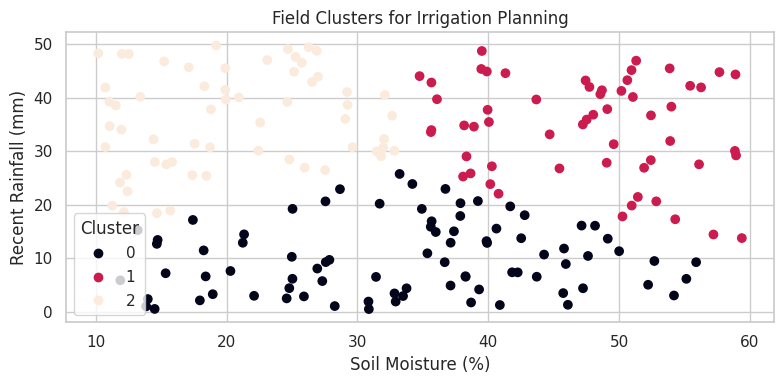

In [22]:
# Plot clusters (using Soil Moisture vs Recent Rainfall)
plt.figure()
scatter = plt.scatter(df_irrig['Soil_Moisture'], df_irrig['Recent_Rainfall'], c=df_irrig['Cluster'])
plt.xlabel('Soil Moisture (%)')
plt.ylabel('Recent Rainfall (mm)')
plt.title('Field Clusters for Irrigation Planning')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.tight_layout()
plt.show()